<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import shutil, os
filename_train = 'oracle_logs'
filename_validation = 'oracle_logs'
if os.path.exists(filename_train):
  shutil.rmtree(filename_train)
if os.path.exists(filename_validation):
  shutil.rmtree(filename_validation)
shutil.unpack_archive(f'{filename_train}.zip', './')
# shutil.unpack_archive('validation.zip', './')
print(len(os.listdir(filename_train)))
# print(len(os.listdir('validation')))
train_filenames = os.listdir(filename_train)[:4000]
# val_filenames = os.listdir('validation')
val_filenames = os.listdir(filename_train)[4000:]
train_filenames.sort()
val_filenames.sort()
print(train_filenames[0], val_filenames[0])

4942
412591.npz 412614.npz


In [58]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [59]:
# Constants
T = 8 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [60]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize, folder_name) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.folder_name = folder_name
    self.boards_per_game = 4
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    legal_moves = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join(self.folder_name, f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
      legal_moves.extend(loaded['legal_moves'][index])
    
    # Y_new = []
    # for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return (np.array(inputs), np.array(legal_moves)), np.array(outputs)

In [61]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True, filename_train)
validation_generator = My_Custom_Generator(val_filenames, batch_size, False, filename_validation)

In [69]:
inputs = tf.keras.Input(shape=(112, 8, 8))
legal_moves_input = tf.keras.Input(shape = (1858))
x1 = tf.keras.layers.LeakyReLU()(inputs)


x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(112, (3, 3), activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(10, (3,3),activation="relu", padding="same", data_format = 'channels_first')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1858, activation = 'relu')(x)


# x = tf.keras.layers.add([x, legal_moves_input])

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs = [inputs, legal_moves_input], outputs = x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 112, 8, 8)]  0           []                               
                                                                                                  
 leaky_re_lu_70 (LeakyReLU)     (None, 112, 8, 8)    0           ['input_37[0][0]']               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 128, 8, 8)    129152      ['leaky_re_lu_70[0][0]']         
                                                                                                  
 batch_normalization_53 (BatchN  (None, 128, 8, 8)   32          ['conv2d_53[0][0]']              
 ormalization)                                                                             

In [70]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [71]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 10,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(min(1000, len(val_filenames)) // batch_size)  # Use only 1000 samples for validation
                  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
125/125 [==============================] - 72s 574ms/step - loss: 5.4569 - categorical_accuracy: 0.1665 - val_loss: 6.8702 - val_categorical_accuracy: 0.1112
Epoch 2/10
125/125 [==============================] - 63s 508ms/step - loss: 4.9374 - categorical_accuracy: 0.2333 - val_loss: 5.8838 - val_categorical_accuracy: 0.1768
Epoch 3/10
125/125 [==============================] - 63s 508ms/step - loss: 4.7297 - categorical_accuracy: 0.2608 - val_loss: 5.4116 - val_categorical_accuracy: 0.2090
Epoch 4/10
125/125 [==============================] - 64s 510ms/step - loss: 4.5946 - categorical_accuracy: 0.2834 - val_loss: 5.3048 - val_categorical_accuracy: 0.2128
Epoch 5/10
125/125 [==============================] - 63s 507ms/step - loss: 4.5273 - categorical_accuracy: 0.2949 - val_loss: 5.2788 - val_categorical_accuracy: 0.2200
Epoch 6/10
125/125 [==============================] - 71s 568ms/step - loss: 4.4751 - categorical_accuracy: 0.3050 - val_loss: 5.2457 - val_categorical_acc

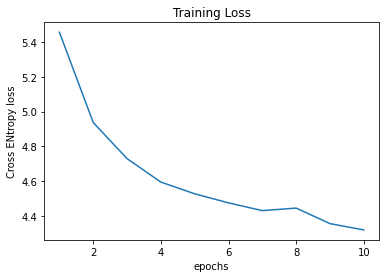

In [73]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

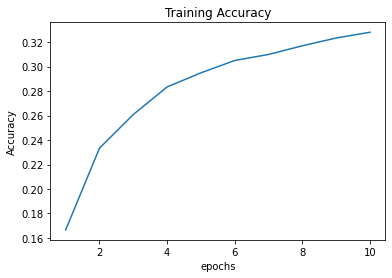

In [76]:
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

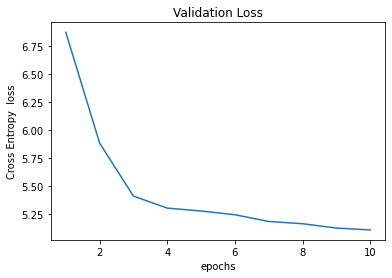

In [75]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy  loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

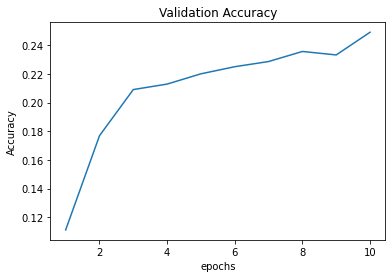

In [77]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [78]:
print(history.history)

{'loss': [5.456868648529053, 4.937417030334473, 4.729699611663818, 4.594610214233398, 4.527276992797852, 4.475076675415039, 4.430450916290283, 4.445039749145508, 4.355615615844727, 4.31943941116333], 'categorical_accuracy': [0.166540265083313, 0.23334597051143646, 0.2608393430709839, 0.28340286016464233, 0.2949058413505554, 0.3050183355808258, 0.3099481761455536, 0.31702691316604614, 0.3234104514122009, 0.3280874788761139], 'val_loss': [6.870179653167725, 5.8838396072387695, 5.4116129875183105, 5.304834842681885, 5.278841018676758, 5.245695114135742, 5.185806751251221, 5.165689468383789, 5.126965522766113, 5.110598087310791], 'val_categorical_accuracy': [0.11118801683187485, 0.1768428385257721, 0.20902754366397858, 0.21283432841300964, 0.22000296413898468, 0.22494685649871826, 0.22855588793754578, 0.23557621240615845, 0.23315370082855225, 0.24897414445877075]}


In [ ]:
from google.colab import files

folder_name = "saved-model"

if os.path.exists(folder_name):
  shutil.rmtree(folder_name)
os.mkdir(folder_name)

if os.path.exists(folder_name + ".zip"):
  os.remove(folder_name + ".zip")
model.save(folder_name)

shutil.make_archive(folder_name, 'zip', folder_name)
files.download(folder_name + ".zip")